### Look at how sea ice advance and retreat timing affects biology

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import pandas as pd
from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath

### Get the CESM2 4p4z tseries files 

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C',
             'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            'IFRAC']

In [3]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.006201-012212.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
spC
coccoC
diatC
zoo1C
zoo2C
zoo3C
zoo4C
x_graze_zoo1_zint
x_graze_zoo2_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_TOT_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
IFRAC
CPU times: user 8.31 s, sys: 633 ms, total: 8.95 s
Wall time: 11.6 s


In [4]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

### trim latitude to the same length as polynas and fix time

In [5]:
ds = ds.isel(nlat=slice(0,76))

In [6]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

### Get coords

In [7]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
ds_grid = ds_grid.isel(nlat=slice(0,76))
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4

ds['z_t']=ds_grid.z_t
depths_m=ds_grid.z_t * 0.01
dz=ds_grid.dz
dz_m=ds_grid.dz * 0.01
tlen=len(ds.time)

### Make the biological variables 2-D

In [8]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint']

Drop the 3-D vars now

In [9]:
ds = ds.drop(['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C'])
ds  = ds.drop(['dz','z_t','z_t_150m'])

In [10]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [11]:
ds

<xarray.Dataset>
Dimensions:            (d2: 2, nlat: 76, nlon: 320, time: 732)
Coordinates:
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
  * time               (time) object 0062-01-16 12:00:00 ... 0122-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    KMT                (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    REGION_MASK        (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    TAREA              (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    time_bound         (time, d2) object dask.array<chunksize=(732, 2), meta=np.ndarray>
    x_graze_zoo1_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    x_graze_zoo2_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    x_graze_zoo3_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    x_graze_zoo4_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    photoC_TOT_zint    (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    photoC_diat_zint   (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    photoC_sp_zint     (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    photoC_cocco_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    IFRAC              (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    zoo1C_zint         (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    zoo2C_zint         (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    zoo3C_zint         (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    zoo4C_zint         (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    zooC_TOT_zint      (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    spC_zint           (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    diatC_zint         (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    coccoC_zint        (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    phytoC_TOT_zint    (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>

## make annual data

In [12]:
%%time
ds_ann = ds.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 3min 8s, sys: 30.9 s, total: 3min 39s
Wall time: 3min 25s


### update the variable list

In [13]:
#redefine variable list
variables = ['phytoC_TOT_zint','zooC_TOT_zint'] # 'spC_zint','coccoC_zint','diatC_zint','zoo1C_zint','zoo2C_zint','zoo3C_zint','zoo4C_zint',
             #'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             #'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            #'IFRAC','phytoC_TOT_zint','zooC_TOT_zint']

### Get sea ice advance /retreat files

Days are Julian days (1-365 although higher allowed for retreat in SH - see below)

Day of advance: first day of ice-year that ice concentration in a grid cell exceeds 15% and remains above 15% for at least 5 days

Day of retreat: first day after ice advance that ice concentration falls below 15% and remains so for remainder of ice-year

Ice year in Southern Hemisphere is defined as Feb 15 yr1 to Feb 14 yr2.

Ice retreat day will tend to be large - and in some cases will actually be >365 as it might fall in Jan or early Feb of following year.


#### get data from laura's files

In [14]:
path = '/glade/p/cesm/pcwg/landrum/'

file = path + case + '/ice/analysis/daily/RetreatAdvance/' + case + '.RetreatAdvance_sh.aice_d.0062-0121.nc'

ds_seaice = xr.open_dataset(file, decode_times=True)


In [15]:
ds_seaice

<xarray.Dataset>
Dimensions:       (ni: 320, nj: 76, year: 60)
Coordinates:
  * year          (year) int32 62 63 64 65 66 67 68 ... 116 117 118 119 120 121
Dimensions without coordinates: ni, nj
Data variables:
    TLAT          (nj, ni) float32 ...
    TLON          (nj, ni) float32 ...
    ice_advance   (year, nj, ni) float64 ...
    ice_retreat   (year, nj, ni) float64 ...
    ice_duration  (year, nj, ni) float64 ...
    ice_ndays     (year, nj, ni) float64 ...
Attributes:
    title:          g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
    program:        /glade/u/home/landrum/CESM_CCSM4/misc_scripts/CESM_IceAdv...
    creation_date:  Fri Aug 13 17:54:49 MDT 2021

### make some adjustment so the two datasets align

• remove year 122 (the last year) from biological vars ds

• rename coords from seaice ds

• overwrite 'time' dimension in the seaice data

In [16]:
ds_ann = ds_ann.isel(time=slice(0,60))

In [17]:
ds_seaice = ds_seaice.rename({'ni': 'nlon','nj': 'nlat','year':'time'})

In [18]:
ds_seaice['time'] = ds_ann.time

In [19]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### DATA IS PREPPED

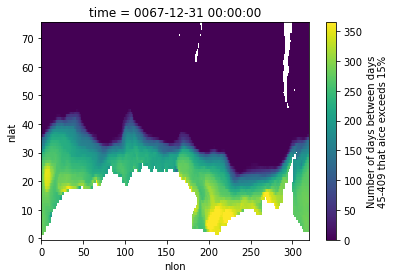

In [20]:
ds_seaice.ice_ndays.isel(time=5).plot()

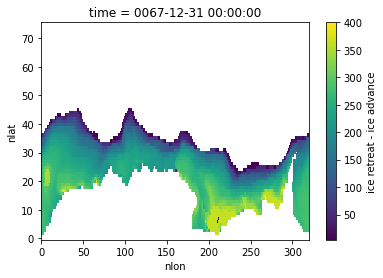

In [21]:
ds_seaice.ice_duration.isel(time=5).plot()

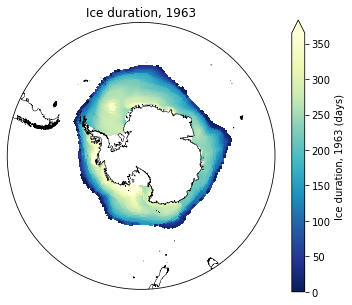

In [22]:
fig = plt.figure(figsize=(6,5))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice duration, 1963')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, ds_seaice.ice_duration.isel(time=5))

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=365, 
                 cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Ice duration, 1963 (days)')

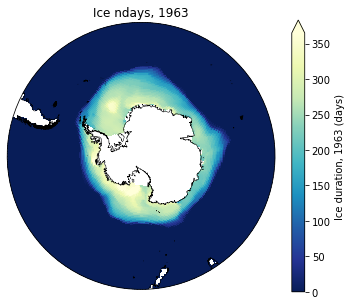

In [23]:
fig = plt.figure(figsize=(6,5))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice ndays, 1963')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, ds_seaice.ice_ndays.isel(time=5))

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=365, 
                 cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Ice duration, 1963 (days)')

In [36]:
zoo_duration_corr = xr.corr(ds_ann.zooC_TOT_zint, ds_seaice.ice_duration, dim='time').squeeze()
phyto_duration_corr = xr.corr(ds_ann.phytoC_TOT_zint, ds_seaice.ice_duration, dim='time').squeeze()

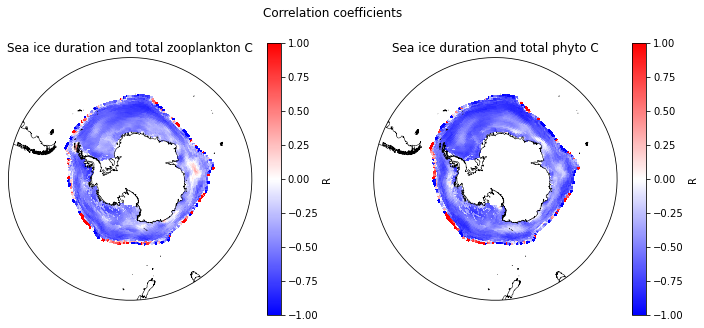

In [37]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Correlation coefficients')
#----------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Sea ice duration and total zooplankton C')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, zoo_duration_corr)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-1, vmax=1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='R')



ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('Sea ice duration and total phyto C')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, phyto_duration_corr)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-1, vmax=1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='R')

In [38]:
ds_seaice

<xarray.Dataset>
Dimensions:       (nlat: 76, nlon: 320, time: 60)
Coordinates:
  * time          (time) object 0062-12-31 00:00:00 ... 0121-12-31 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT          (nlat, nlon) float32 -79.22 -79.22 -79.22 ... -39.15 -39.15
    TLON          (nlat, nlon) float32 320.6 321.7 322.8 ... 317.2 318.3 319.4
    ice_advance   (time, nlat, nlon) float64 ...
    ice_retreat   (time, nlat, nlon) float64 ...
    ice_duration  (time, nlat, nlon) float64 ...
    ice_ndays     (time, nlat, nlon) float64 ...
Attributes:
    title:          g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
    program:        /glade/u/home/landrum/CESM_CCSM4/misc_scripts/CESM_IceAdv...
    creation_date:  Fri Aug 13 17:54:49 MDT 2021

In [39]:
phyto_ice_ndays_corr = xr.corr(ds_ann.phytoC_TOT_zint, ds_seaice.ice_ndays, dim='time').squeeze()
zoo_ice_ndays_corr = xr.corr(ds_ann.zooC_TOT_zint, ds_seaice.ice_ndays, dim='time').squeeze()

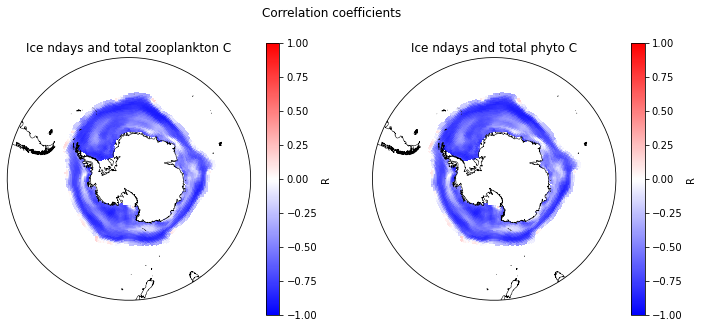

In [40]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Correlation coefficients')
#----------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice ndays and total zooplankton C')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, zoo_ice_ndays_corr)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-1, vmax=1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='R')



ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice ndays and total phyto C')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, phyto_ice_ndays_corr)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-1, vmax=1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='R')

In [42]:
phyto_retreat_corr = xr.corr(ds_ann.phytoC_TOT_zint, ds_seaice.ice_retreat, dim='time').squeeze()
zoo_retreat_corr = xr.corr(ds_ann.zooC_TOT_zint, ds_seaice.ice_retreat, dim='time').squeeze()

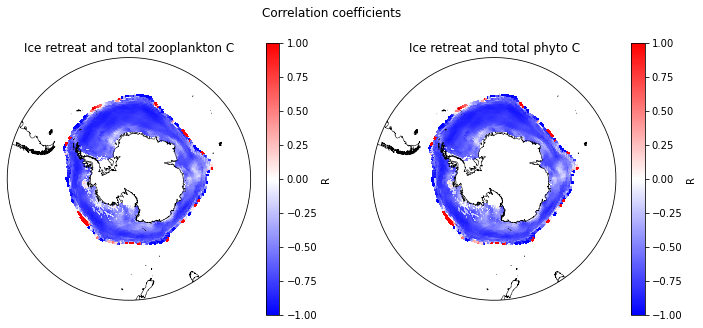

In [43]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Correlation coefficients')
#----------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice retreat and total zooplankton C')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, zoo_retreat_corr)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-1, vmax=1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='R')



ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice retreat and total phyto C')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, phyto_retreat_corr)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-1, vmax=1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='R')

In [44]:
phyto_advance_corr = xr.corr(ds_ann.phytoC_TOT_zint, ds_seaice.ice_advance, dim='time').squeeze()
zoo_advance_corr = xr.corr(ds_ann.zooC_TOT_zint, ds_seaice.ice_advance, dim='time').squeeze()

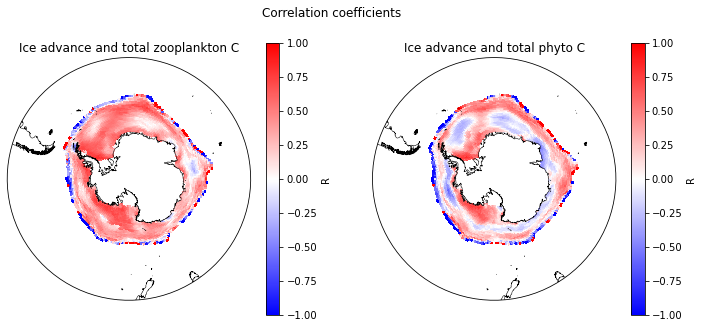

In [45]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Correlation coefficients')
#----------
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice advance and total zooplankton C')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, zoo_advance_corr)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-1, vmax=1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='R')



ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('Ice advance and total phyto C')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

lon, lat, field = adjust_pop_grid(lons, lats, phyto_advance_corr)

#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=-1, vmax=1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='R')